The baseline was taken from [CMI | Reproducible results |FixSeed,LGB-CPU|LB.494](https://www.kaggle.com/code/kuosys/cmi-reproducible-results-fixseed-lgb-cpu-lb-494) 🙏

# Metric Exploration

Submissions are scored based on the quadratic weighted kappa, which measures the agreement between two outcomes. This metric typically varies from 0 (random agreement) to 1 (complete agreement). In the event that there is less agreement than expected by chance, the metric may go below 0.

To compute the quadratic weighted kappa, we construct three matrices, $O$, $W$, and $E$, with $N$ the number of distinct labels.

The matrix $O$ is an $N × 𝑁$ histogram matrix such that $O_{i,j}$ corresponds to the number of instances that have an actual value $i$ and a predicted value $j$.

The matrix $W$ is an $N × 𝑁$ matrix of weights, calculated based on the squared difference between actual and predicted values:

$$ W_{i,j} = \frac{(i - j)^2}{(N - 1)^2}.$$

The matrix $E$ is an $N × 𝑁$ histogram matrix of expected outcomes, calculated assuming that there is no correlation between values. This is calculated as the outer product between the actual histogram vector of outcomes and the predicted histogram vector, normalized such that $E$ and $O$ have the same sum.

From these three matrices, the quadratic weighted kappa is calculated as: 

$$𝜅 = 1 - \frac{\sum_{i, j} W_{i, j} \cdot O_{i, j}}{\sum_{i, j} W_{i, j} \cdot E_{i, j}}.$$

This metric can be interpreted as one minus the ratio of the squared error on the predicted values ​​to the error if we had randomly assigned predictions from a class distribution given by the proportions of predicted values. To learn more about this metric, you can find detailed information online, for example at [https://datatab.net/tutorial/weighted-cohens-kappa](https://datatab.net/tutorial/weighted-cohens-kappa).

In [1]:
import numpy as np
import pandas as pd
import os
import re
import copy
import pickle
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import DataLoader, TensorDataset
from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline

import plotly.express as px

warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [2]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    print('OPTIMIZED THRESHOLDS', KappaOPtimizer.x)
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })
    optimized_thresholds = KappaOPtimizer.x
    return submission, oof_tuned, oof_non_rounded, y, optimized_thresholds

100%|██████████| 2/2 [00:00<00:00, 11.03it/s]


In [3]:
SEED = 42
n_splits = 5

model = XGBRegressor(
    learning_rate=0.05,
    max_depth=6,
    n_estimators=200,
    subsample=0.8,
    colsample_bytree = 0.8,
    reg_alpha=1,
    reg_lambda=5,
    random_state=SEED
)

# we get out of fold predictions for further exploration
submission, y_pred, y_pred_non_rounded, y_true, optimized_thresholds = TrainML(model, test)

Training Folds: 100%|██████████| 5/5 [00:22<00:00,  4.48s/it]

Mean Train QWK --> 0.8939
Mean Validation QWK ---> 0.3897


OPTIMIZED THRESHOLDS [0.6264773  0.89171596 2.75349008]
----> || Optimized QWK SCORE ::  0.445


Next, we simulate changes in the scores by adding one more observation (with classes 0, 1, 2, 3 specified by `y_new`) and calculate how much better/worse the metric becomes at different values of the predictions `pred_new` compared to the prediction 0.

In [4]:
df_score_changes = []
for y_new in range(4):
    item = {'y_new': y_new}
    score_pred_zero = quadratic_weighted_kappa(list(y_true) + [y_new], list(y_pred) + [0])
    for pred_new in range(4):
        score = quadratic_weighted_kappa(list(y_true) + [y_new], list(y_pred) + [pred_new])
        item[f'pred_new={pred_new}'] = score - score_pred_zero
    df_score_changes.append(item)

df_score_changes = pd.DataFrame(df_score_changes)
df_score_changes

,y_new,pred_new=0,pred_new=1,pred_new=2,pred_new=3
0,0,0.0,-0.000313,-0.000880,-0.001701
1,1,0.0,0.000261,0.000267,0.000018
2,2,0.0,0.000835,0.001415,0.001738
3,3,0.0,0.001407,0.002559,0.003454


Our analysis reveals that when `y_new=2`, predicting class 3 results in a higher score than predicting the true class 2 for a one addtional observation 🤯

Let's plot the change in the metric as we vary the threshold (while keeping the others fixed).

In [5]:
for t_idx in range(3):
    df_plot = []
    for t in np.arange(0.0, 3.0, 0.001):
        thresholds = copy.copy(optimized_thresholds)
        thresholds[t_idx] = t
        score = -evaluate_predictions(thresholds, y_true, y_pred_non_rounded)
        df_plot.append({f't_{t_idx}': t, 'score': score})
    
    df_plot = pd.DataFrame(df_plot)
    fig = px.line(df_plot, x=f't_{t_idx}', y='score', title=f't_{t_idx}')
    fig.show(renderer='iframe')

In [6]:
# The threshold optimizer in the code appears to be finding a local maximum, not the global maximum
print('optimized_thresholds score:', -evaluate_predictions(optimized_thresholds, y_true, y_pred_non_rounded))
print('another thresholds score:', -evaluate_predictions([0.6264773 , 0.89171596, 1.64], y_true, y_pred_non_rounded))

optimized_thresholds score: 0.4447091772741697
another thresholds score: 0.4528701027295803


# Issues with the Quadratic Weighted Kappa metric

* **Non-intuitive behavior:** It's been shown that predicting incorrect values can sometimes result in a better QWK score than predicting the actual values. This highlights the complexity of interpreting changes in the metric and can make it difficult to understand whether model improvements are truly meaningful.
* **Loss of information due to discretization:** QWK requires discrete predictions, which means continuous model outputs need to be thresholded into distinct categories. This process can obscure a significant amount of information about the model's performance. For example, QWK doesn't consider how well items are ranked within each predicted class. Items on the edge of thresholds and those deep inside a category are treated equally, potentially masking important distinctions. In my opinion, a continuous metric might provide a more nuanced and informative assessment of model quality, potentially leading to better business decisions.

# BASELINE

# Issues with the following baseline (as well as in similar top-performing models on a public dataset)
* Autoencoder for `train` and `test` dataset is fitted separately and it might lead to severely different encoding for the same data (see using `perform_autoencoder`)
* Thresholds optimizer finds only local extremum (see using `KappaOPtimizer = minimize(...)`)

Incredibly, this dubious technique gives a good score on the public leaderboard 🤷. Let's hope that for private dataset something more correct will work better 🙏.

In [7]:
!pip -q install /kaggle/input/pytorchtabnet/pytorch_tabnet-4.1.0-py3-none-any.whl

In [8]:
from pytorch_tabnet.tab_model import TabNetRegressor
import torch

In [9]:
import numpy as np
import pandas as pd
import os
import re
from sklearn.base import clone
from sklearn.metrics import cohen_kappa_score
from sklearn.model_selection import StratifiedKFold
from scipy.optimize import minimize
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
import polars as pl
import polars.selectors as cs
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, FormatStrFormatter, PercentFormatter
import seaborn as sns

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import torch
import torch.nn as nn
import torch.optim as optim

from colorama import Fore, Style
from IPython.display import clear_output
import warnings
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import VotingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None

In [10]:
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything(2024)

In [11]:
SEED = 42
n_splits = 5

# Feature Engineering

- **Feature Selection**: The dataset contains features related to physical characteristics (e.g., BMI, Height, Weight), behavioral aspects (e.g., internet usage), and fitness data (e.g., endurance time). 
- **Categorical Feature Encoding**: Categorical features are mapped to numerical values using custom mappings for each unique category within the dataset. This ensures compatibility with machine learning algorithms that require numerical input.
- **Time Series Aggregation**: Time series statistics (e.g., mean, standard deviation) from the actigraphy data are computed and merged into the main dataset to create additional features for model training.


In [12]:
# Sparse Autoencoder Model
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim, sparsity_weight=1e-5):
        super(SparseAutoencoder, self).__init__()
        self.sparsity_weight = sparsity_weight
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, input_dim),
            nn.Sigmoid()  # Outputs in the range [0, 1]
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

# Preparing Data
# Option to use different scalers: MinMaxScaler, StandardScaler, RobustScaler
def prepare_data(data, scaler_type='MinMaxScaler'):
    if scaler_type == 'StandardScaler':
        scaler = StandardScaler()
    elif scaler_type == 'RobustScaler':
        scaler = RobustScaler()
    else:
        scaler = MinMaxScaler()
    
    data_scaled = scaler.fit_transform(data)
    return torch.tensor(data_scaled, dtype=torch.float32), scaler

# Apply PCA for Dimensionality Reduction
# This can help focus the autoencoder on the most relevant features
def apply_pca(data, n_components=0.95):
    pca = PCA(n_components=n_components)
    data_pca = pca.fit_transform(data)
    return data_pca, pca

# Early Stopping Functionality
def early_stopping(patience):
    class EarlyStopping:
        def __init__(self, patience=patience):
            self.patience = patience
            self.counter = 0
            self.best_loss = float('inf')
            self.early_stop = False
        
        def __call__(self, loss):
            if loss < self.best_loss:
                self.best_loss = loss
                self.counter = 0
            else:
                self.counter += 1
                if self.counter >= self.patience:
                    self.early_stop = True
    return EarlyStopping()

# Training the Sparse Autoencoder with DataFrame Output
def perform_autoencoder(data, epochs=100, batch_size=32, learning_rate=0.001, patience=10, scaler_type='MinMaxScaler', use_pca=False, sparsity_weight=1e-5):
    # Preprocess Data
    if use_pca:
        data, pca = apply_pca(data)

    data_tensor, scaler = prepare_data(data, scaler_type=scaler_type)
    train_data, val_data = train_test_split(data_tensor, test_size=0.2, random_state=42)

    train_loader = DataLoader(TensorDataset(train_data), batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(TensorDataset(val_data), batch_size=batch_size, shuffle=False)

    model = SparseAutoencoder(input_dim=data.shape[1], sparsity_weight=sparsity_weight)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.SmoothL1Loss()  # Changed to Smooth L1 Loss
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    stopper = early_stopping(patience=patience)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in train_loader:
            batch = batch[0].to(device)
            optimizer.zero_grad()
            encoded, outputs = model(batch)
            
            # Reconstruction loss
            loss = criterion(outputs, batch)
            
            # Sparsity penalty (L1 regularization on encoded activations)
            l1_penalty = torch.mean(torch.abs(encoded))
            loss += sparsity_weight * l1_penalty
            
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * batch.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch[0].to(device)
                _, outputs = model(batch)
                loss = criterion(outputs, batch)
                val_loss += loss.item() * batch.size(0)

        val_loss /= len(val_loader.dataset)
        print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

        # Early stopping
        stopper(val_loss)
        if stopper.early_stop:
            print(f"Early stopping at epoch {epoch + 1}")
            break

    # Convert tensor back to DataFrame for consistency
    _, data_decoded = model(data_tensor.to(device))
    data_decoded = data_decoded.cpu().detach().numpy()
    df_encoded = pd.DataFrame(data_decoded, columns=[f'feature_{i}' for i in range(data_decoded.shape[1])])
    return df_encoded

In [13]:
def feature_engineering(df):
    season_cols = [col for col in df.columns if 'Season' in col]
    df = df.drop(season_cols, axis=1) 
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['BFP_BMR'] = df['BIA-BIA_Fat'] * df['BIA-BIA_BMR']
    df['BFP_DEE'] = df['BIA-BIA_Fat'] * df['BIA-BIA_DEE']
    df['BMR_Weight'] = df['BIA-BIA_BMR'] / df['Physical-Weight']
    df['DEE_Weight'] = df['BIA-BIA_DEE'] / df['Physical-Weight']
    df['SMM_Height'] = df['BIA-BIA_SMM'] / df['Physical-Height']
    df['Muscle_to_Fat'] = df['BIA-BIA_SMM'] / df['BIA-BIA_FMI']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    df['BMI_PHR'] = df['Physical-BMI'] * df['Physical-HeartRate']
    
    return df

train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

df_train = train_ts.drop('id', axis=1)
df_test = test_ts.drop('id', axis=1)

train_ts_encoded = perform_autoencoder(df_train, epochs=100, batch_size=32, learning_rate=0.001, patience=10, use_pca=False, scaler_type='MinMaxScaler', sparsity_weight=1e-5)
test_ts_encoded = perform_autoencoder(df_test, epochs=100, batch_size=32, learning_rate=0.001, patience=10, use_pca=False, scaler_type='MinMaxScaler', sparsity_weight=1e-5)

time_series_cols = train_ts_encoded.columns.tolist()
train_ts_encoded["id"]=train_ts["id"]
test_ts_encoded['id']=test_ts["id"]

train = pd.merge(train, train_ts_encoded, how="left", on='id')
test = pd.merge(test, test_ts_encoded, how="left", on='id')

imputer = KNNImputer(n_neighbors=5)
numeric_cols = train.select_dtypes(include=['float64', 'int64']).columns
imputed_data = imputer.fit_transform(train[numeric_cols])
train_imputed = pd.DataFrame(imputed_data, columns=numeric_cols)
train_imputed['sii'] = train_imputed['sii'].round().astype(int)
for col in train.columns:
    if col not in numeric_cols:
        train_imputed[col] = train[col]
        
train = train_imputed

train = feature_engineering(train)
train = train.dropna(thresh=10, axis=0)
test = feature_engineering(test)

train = train.drop('id', axis=1)
test  = test .drop('id', axis=1)   


featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'sii', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW','BMI_PHR']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

featuresCols = ['Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-CGAS_Score', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-PAQ_A_Total',
                'PAQ_C-PAQ_C_Total', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T',
                'PreInt_EduHx-computerinternet_hoursday', 'BMI_Age','Internet_Hours_Age','BMI_Internet_Hours',
                'BFP_BMI', 'FFMI_BFP', 'FMI_BFP', 'LST_TBW', 'BFP_BMR', 'BFP_DEE', 'BMR_Weight', 'DEE_Weight',
                'SMM_Height', 'Muscle_to_Fat', 'Hydration_Status', 'ICW_TBW','BMI_PHR']

featuresCols += time_series_cols
test = test[featuresCols]

100%|██████████| 2/2 [00:00<00:00, 12.93it/s]


Epoch 1, Train Loss: 0.0485, Validation Loss: 0.0436
Epoch 2, Train Loss: 0.0304, Validation Loss: 0.0210
Epoch 3, Train Loss: 0.0190, Validation Loss: 0.0185
Epoch 4, Train Loss: 0.0182, Validation Loss: 0.0182
Epoch 5, Train Loss: 0.0181, Validation Loss: 0.0182
Epoch 6, Train Loss: 0.0180, Validation Loss: 0.0182
Epoch 7, Train Loss: 0.0180, Validation Loss: 0.0182
Epoch 8, Train Loss: 0.0180, Validation Loss: 0.0181
Epoch 9, Train Loss: 0.0179, Validation Loss: 0.0180
Epoch 10, Train Loss: 0.0178, Validation Loss: 0.0179
Epoch 11, Train Loss: 0.0177, Validation Loss: 0.0177
Epoch 12, Train Loss: 0.0175, Validation Loss: 0.0175
Epoch 13, Train Loss: 0.0171, Validation Loss: 0.0168
Epoch 14, Train Loss: 0.0162, Validation Loss: 0.0153
Epoch 15, Train Loss: 0.0147, Validation Loss: 0.0134
Epoch 16, Train Loss: 0.0132, Validation Loss: 0.0124
Epoch 17, Train Loss: 0.0124, Validation Loss: 0.0117
Epoch 18, Train Loss: 0.0117, Validation Loss: 0.0111
Epoch 19, Train Loss: 0.0112, Validat

In [14]:
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

In [15]:
def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    
    oof_tuned = threshold_Rounder(oof_non_rounded, KappaOPtimizer.x)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tpTuned = threshold_Rounder(tpm, KappaOPtimizer.x)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission


# Hyperparameter Tuning

- **LightGBM Parameters**: Hyperparameters such as `learning_rate`, `max_depth`, `num_leaves`, and `feature_fraction` are tuned to improve the performance of the LightGBM model. These parameters control the complexity of the model and its ability to generalize to new data.
- **XGBoost and CatBoost Parameters**: Similar tuning is applied for XGBoost and CatBoost, adjusting parameters such as `n_estimators`, `max_depth`, `learning_rate`, `subsample`, and `regularization` terms (`reg_alpha`, `reg_lambda`). These help in controlling overfitting and ensuring the model's robustness.

In [16]:
# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01,  # Increased from 2.68e-06
    'device': 'cpu'

}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED,
    'tree_method': 'gpu_hist',

}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'verbose': 0,
    'l2_leaf_reg': 10,  # Increase this value
    'task_type': 'GPU'

}

In [17]:
# New: TabNet

from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from pytorch_tabnet.callbacks import Callback
import os
import torch
from pytorch_tabnet.callbacks import Callback

class TabNetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = TabNetRegressor(**kwargs)
        self.kwargs = kwargs
        self.imputer = SimpleImputer(strategy='median')
        self.best_model_path = 'best_tabnet_model.pt'
        
    def fit(self, X, y):
        # Handle missing values
        X_imputed = self.imputer.fit_transform(X)
        
        if hasattr(y, 'values'):
            y = y.values
            
        # Create internal validation set
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_imputed, 
            y, 
            test_size=0.2,
            random_state=42
        )
        
        # Train TabNet model
        history = self.model.fit(
            X_train=X_train,
            y_train=y_train.reshape(-1, 1),
            eval_set=[(X_valid, y_valid.reshape(-1, 1))],
            eval_name=['valid'],
            eval_metric=['mse'],
            max_epochs=200,
            patience=20,
            batch_size=1024,
            virtual_batch_size=128,
            num_workers=0,
            drop_last=False,
            callbacks=[
                TabNetPretrainedModelCheckpoint(
                    filepath=self.best_model_path,
                    monitor='valid_mse',
                    mode='min',
                    save_best_only=True,
                    verbose=True
                )
            ]
        )
        
        # Load the best model
        if os.path.exists(self.best_model_path):
            self.model.load_model(self.best_model_path)
            os.remove(self.best_model_path)  # Remove temporary file
        
        return self
    
    def predict(self, X):
        X_imputed = self.imputer.transform(X)
        return self.model.predict(X_imputed).flatten()
    
    def __deepcopy__(self, memo):
        # Add deepcopy support for scikit-learn
        cls = self.__class__
        result = cls.__new__(cls)
        memo[id(self)] = result
        for k, v in self.__dict__.items():
            setattr(result, k, deepcopy(v, memo))
        return result

# TabNet hyperparameters
TabNet_Params = {
    'n_d': 64,              # Width of the decision prediction layer
    'n_a': 64,              # Width of the attention embedding for each step
    'n_steps': 5,           # Number of steps in the architecture
    'gamma': 1.5,           # Coefficient for feature selection regularization
    'n_independent': 2,     # Number of independent GLU layer in each GLU block
    'n_shared': 2,          # Number of shared GLU layer in each GLU block
    'lambda_sparse': 1e-4,  # Sparsity regularization
    'optimizer_fn': torch.optim.Adam,
    'optimizer_params': dict(lr=2e-2, weight_decay=1e-5),
    'mask_type': 'entmax',
    'scheduler_params': dict(mode="min", patience=10, min_lr=1e-5, factor=0.5),
    'scheduler_fn': torch.optim.lr_scheduler.ReduceLROnPlateau,
    'verbose': 1,
    'device_name': 'cuda' if torch.cuda.is_available() else 'cpu'
}

class TabNetPretrainedModelCheckpoint(Callback):
    def __init__(self, filepath, monitor='val_loss', mode='min', 
                 save_best_only=True, verbose=1):
        super().__init__()  # Initialize parent class
        self.filepath = filepath
        self.monitor = monitor
        self.mode = mode
        self.save_best_only = save_best_only
        self.verbose = verbose
        self.best = float('inf') if mode == 'min' else -float('inf')
        
    def on_train_begin(self, logs=None):
        self.model = self.trainer  # Use trainer itself as model
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)
        if current is None:
            return
        
        # Check if current metric is better than best
        if (self.mode == 'min' and current < self.best) or \
           (self.mode == 'max' and current > self.best):
            if self.verbose:
                print(f'\nEpoch {epoch}: {self.monitor} improved from {self.best:.4f} to {current:.4f}')
            self.best = current
            if self.save_best_only:
                self.model.save_model(self.filepath)  # Save the entire model

In [18]:
# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)
TabNet_Model = TabNetWrapper(**TabNet_Params) # New

---
# **》》》Model1.Train**
---

Unique clusters: 29
Noise points: 3582
Cluster 'sii' modes:
-1     0.0
 0     1.0
 1     0.0
 2     1.0
 3     1.0
 4     0.0
 5     0.0
 6     0.0
 7     1.0
 8     0.0
 9     0.0
 10    0.0
 11    0.0
 12    0.0
 13    1.0
 14    2.0
 15    0.0
 16    0.0
 17    0.0
 18    1.0
 19    0.0
 20    0.0
 21    1.0
 22    0.0
 23    0.0
 24    2.0
 25    1.0
 26    1.0
 27    1.0
 28    1.0
dtype: float64


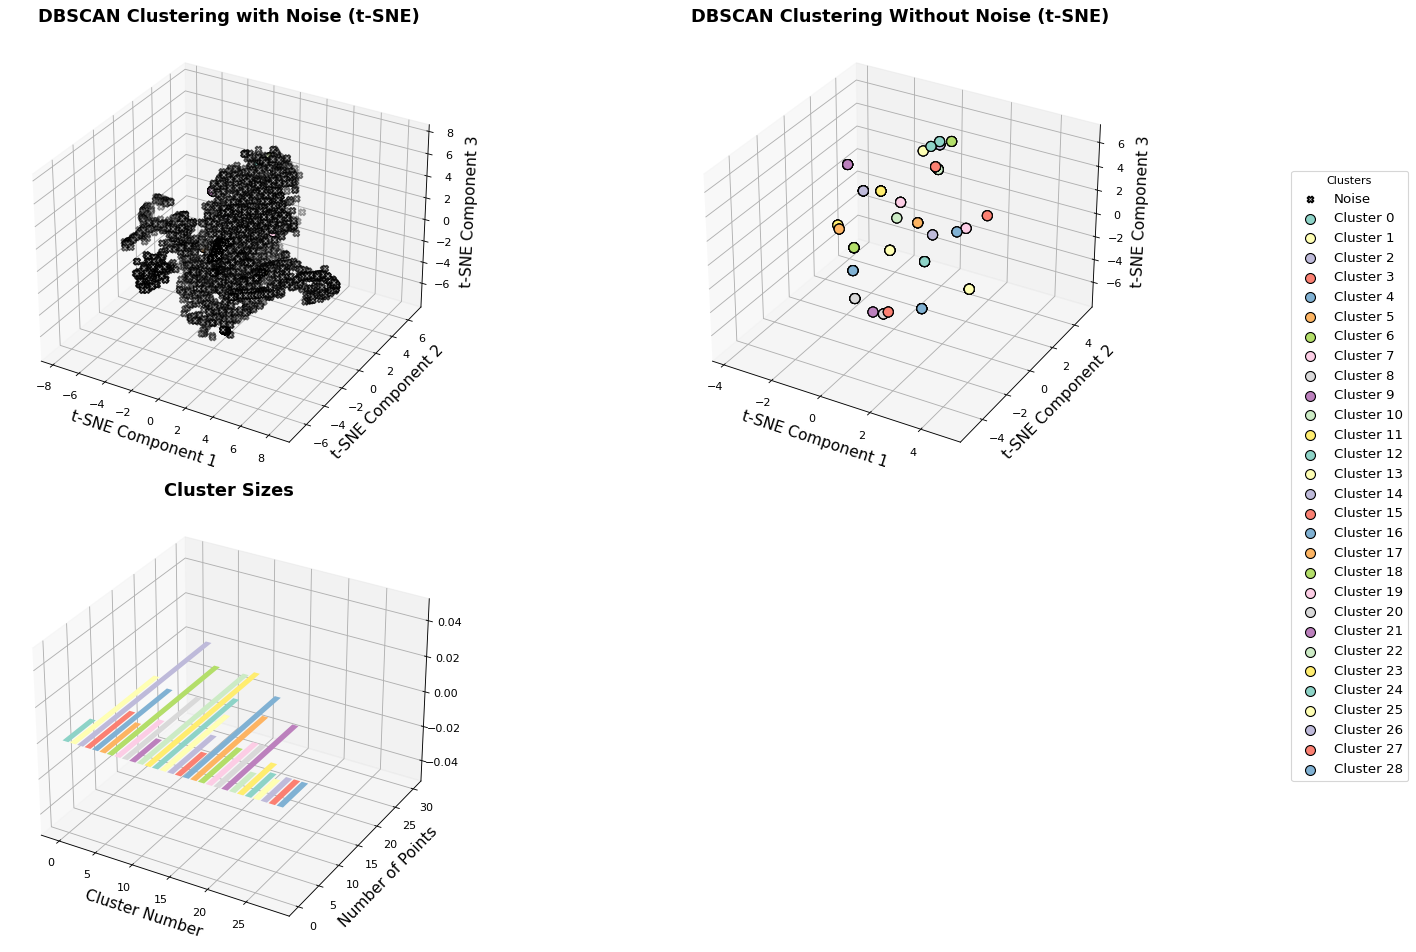

In [19]:
if np.any(np.isinf(train)):
    train = train.replace([np.inf, -np.inf], np.nan)
train_df_le = train
test_df_le = test

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D

# Example train_df_le and test_df_le (replace with actual data)
# train_df_le = pd.read_csv("train_data.csv")
# test_df_le = pd.read_csv("test_data.csv")

# Save the 'sii' column
train_sii = train_df_le['sii'].copy()

# Find common columns between train and test data
common_columns = train_df_le.columns.intersection(test_df_le.columns)
train_df_le = train_df_le[common_columns]
test_df_le = test_df_le[common_columns]
train_df_le['sii'] = train_sii

# Pipeline: Fill missing values with the mean
preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')), 
])

y = train_df_le['sii']
train_df_le = train_df_le.drop(columns=['sii'])
train_df_le = preprocessor.fit_transform(train_df_le)
train_df_le = pd.DataFrame(train_df_le, columns=common_columns)
train_df_le['sii'] = y

# Standardize numerical columns
numeric_cols = train_df_le.select_dtypes(include=[np.number]).columns  
numeric_cols = numeric_cols.drop('sii')  # Exclude 'sii'
scaler = StandardScaler()
train_df_le[numeric_cols] = scaler.fit_transform(train_df_le[numeric_cols])

# Preprocess the test data
test_df_le = preprocessor.transform(test_df_le)
test_df_le = pd.DataFrame(test_df_le, columns=common_columns)
test_df_le[numeric_cols] = scaler.transform(test_df_le[numeric_cols])

# Perform DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  
train_clusters = dbscan.fit_predict(train_df_le)

print(f"Unique clusters: {len(np.unique(train_clusters[train_clusters != -1]))}")
print(f"Noise points: {np.sum(train_clusters == -1)}")

# Find the mode of 'sii' for each cluster
cluster_modes = pd.Series(index=np.unique(train_clusters), dtype=float)

for cluster_num in np.unique(train_clusters):  
    cluster_rows = train_df_le[train_clusters == cluster_num]
    cluster_sii = y[train_clusters == cluster_num]  # 'sii'
    cluster_modes[cluster_num] = cluster_sii.mode()[0] 

print("Cluster 'sii' modes:")
print(cluster_modes)

# Fill missing 'sii' values based on the cluster modes
train_df_le.loc[train_df_le['sii'].isnull(), 'sii'] = [
    cluster_modes[train_clusters[i]] for i in range(len(train_clusters))
]
X = train_df_le

# Perform t-SNE to reduce dimensions to 3D for visualization
tsne = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=300)
train_df_le_tsne = tsne.fit_transform(train_df_le)

# DBSCAN clustering results (-1 indicates noise)
train_clusters = dbscan.labels_

# Set up the plot size and layout (3 plots: 2 for 3D, 1 for bar chart)
fig, axes = plt.subplots(2, 2, figsize=(18, 12), dpi=80, subplot_kw={'projection': '3d'})

# Define custom color palette for clusters (using a seaborn color palette)
num_clusters = len(np.unique(train_clusters)) - 1  # Exclude noise (-1)
palette = sns.color_palette("Set3", n_colors=num_clusters)

# Plot 1: Clusters and Noise Points
ax1 = axes[0, 0]
# Plot the clustering results in 3D, with clusters in distinct colors
for cluster_num in np.unique(train_clusters):
    if cluster_num == -1:  # Noise points
        ax1.scatter(train_df_le_tsne[train_clusters == cluster_num, 0], 
                    train_df_le_tsne[train_clusters == cluster_num, 1], 
                    train_df_le_tsne[train_clusters == cluster_num, 2], 
                    color='lightgray', label='Noise', s=30, marker='X', edgecolor='k', linewidth=1.5)
    else:  # Clusters
        ax1.scatter(train_df_le_tsne[train_clusters == cluster_num, 0], 
                    train_df_le_tsne[train_clusters == cluster_num, 1], 
                    train_df_le_tsne[train_clusters == cluster_num, 2], 
                    color=palette[cluster_num % len(palette)], 
                    label=f'Cluster {cluster_num}', s=80, edgecolor='k', marker='o')

# Plot titles and labels
ax1.set_title('DBSCAN Clustering with Noise (t-SNE)', fontsize=16, weight='bold')
ax1.set_xlabel('t-SNE Component 1', fontsize=14)
ax1.set_ylabel('t-SNE Component 2', fontsize=14)
ax1.set_zlabel('t-SNE Component 3', fontsize=14)

# Plot 2: Clusters Only (Noise excluded)
ax2 = axes[0, 1]
# Plot clusters excluding noise points
for cluster_num in np.unique(train_clusters):
    if cluster_num != -1:  # Exclude Noise points
        ax2.scatter(train_df_le_tsne[train_clusters == cluster_num, 0], 
                    train_df_le_tsne[train_clusters == cluster_num, 1], 
                    train_df_le_tsne[train_clusters == cluster_num, 2], 
                    color=palette[cluster_num % len(palette)], 
                    label=f'Cluster {cluster_num}', s=80, edgecolor='k', marker='o')

# Plot titles and labels for the second plot
ax2.set_title('DBSCAN Clustering Without Noise (t-SNE)', fontsize=16, weight='bold')
ax2.set_xlabel('t-SNE Component 1', fontsize=14)
ax2.set_ylabel('t-SNE Component 2', fontsize=14)
ax2.set_zlabel('t-SNE Component 3', fontsize=14)

# Bar chart: Cluster Sizes
ax3 = axes[1, 0]
# Calculate the number of points in each cluster (excluding noise)
cluster_sizes = pd.Series(train_clusters).value_counts().sort_index()
# Exclude the noise cluster (-1)
cluster_sizes = cluster_sizes[cluster_sizes.index != -1]

# Plot the bar chart of cluster sizes
ax3.bar(cluster_sizes.index, cluster_sizes.values, color=palette[:len(cluster_sizes)])
ax3.set_title('Cluster Sizes', fontsize=16, weight='bold')
ax3.set_xlabel('Cluster Number', fontsize=14)
ax3.set_ylabel('Number of Points', fontsize=14)

# Remove the unnecessary fourth plot (bottom-right)
fig.delaxes(axes[1, 1])

# Add color legend for the clusters on the right side
fig.tight_layout()

# Add color legend for the clusters outside the plot area
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12, title="Clusters")

plt.show()

In [20]:
X = X.drop(columns=["sii"])

In [21]:
import time
import optuna
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import StackingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
import torch
from torch import nn, optim
import pandas as pd

# # Fill missing values in X (features)
# X.fillna(X.mean(), inplace=True)

# # If the target variable also contains NaNs
# y.fillna(y.mean(), inplace=True)

# # For the test set
# test_df_le.fillna(test_df_le.mean(), inplace=True)

# PyTorch Model Definition
class PyTorchRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, input_dim=None, hidden_dim=128, epochs=150, batch_size=32, learning_rate=1e-4, seed=42, device='cpu'):
        # Hyperparameters initialization
        self.hidden_dim = hidden_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.seed = seed
        self.device = device
        
        # Set random seed for reproducibility
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)
        
        # Initialize model and input dimension
        self.model = None
        self.input_dim = input_dim  # Set input dimension dynamically
        
        # Variables to store the scaler and target variable scaling
        self.scaler = StandardScaler()
        self.y_mean = None
        self.y_std = None

    def _build_model(self):
        # Define the architecture of the model
        model = nn.Sequential(
            nn.Linear(self.input_dim, self.hidden_dim),  # Input layer
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(self.hidden_dim, self.hidden_dim),  # Hidden layer
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(self.hidden_dim, 1)  # Output layer (for regression task, 1 output)
        )
        return model.to(self.device)

    def fit(self, X, y):
        # Automatically set input dimension based on the input data shape
        self.input_dim = X.shape[1]  # Dynamically obtain the number of features
        self.model = self._build_model()  # Rebuild the model with the correct input dimension
        
        self.model.train()  # Set the model to training mode
        
        # Normalize input data
        X_scaled = self.scaler.fit_transform(X)  # Standardize the input features
        X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
        
        # Normalize target variable
        self.y_mean, self.y_std = y.mean(), y.std()  # Store the mean and std of y
        y_scaled = (y - self.y_mean) / self.y_std  # Standardize the target variable
        
        # If y is a Pandas Series, convert it to a NumPy array
        if isinstance(y_scaled, pd.Series):
            y_scaled = y_scaled.values
        
        y_tensor = torch.tensor(y_scaled, dtype=torch.float32).view(-1, 1).to(self.device)

        # Use DataLoader for batch processing
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # Training loop
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        self.criterion = nn.MSELoss()

        for epoch in range(self.epochs):
            epoch_loss = 0.0
            for batch_X, batch_y in dataloader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)  # Forward pass
                loss = self.criterion(outputs, batch_y)  # Compute loss
                loss.backward()  # Backward pass
                self.optimizer.step()  # Update parameters using optimizer
                epoch_loss += loss.item()

            # Print loss every 10 epochs
            if epoch % 10 == 0:
                print(f"Epoch [{epoch}/{self.epochs}], Loss: {epoch_loss/len(dataloader):.4f}")

        return self

    def predict(self, X):
        self.model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient computation during inference
            X_scaled = self.scaler.transform(X)  # Standardize input features
            X_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(self.device)
                
            outputs = self.model(X_tensor).squeeze().cpu().numpy()  # Convert output to a NumPy array
            
            # Reverse the scaling of the predictions
            return outputs * self.y_std + self.y_mean  # Undo scaling to return predictions to the original scale

# Initialize the PyTorch model
input_dim = 317  # Set this according to your data
pytorch_model = PyTorchRegressor(input_dim=input_dim, 
                                 hidden_dim=128, 
                                 epochs=150, 
                                 batch_size=32, 
                                 learning_rate=1e-4, 
                                 seed=42, 
                                 device='cuda' if torch.cuda.is_available() else 'cpu')

# Define your other base models
base_models = [
    ('lgb', LGBMRegressor(**Params, verbose=-1)),
    ('xgb', XGBRegressor(**XGB_Params)),
    ('cat', CatBoostRegressor(**CatBoost_Params)),
    ('pytorch', pytorch_model),  # Add PyTorch model to the base models
    ('TabNet_Model', TabNetWrapper(**TabNet_Params)),
]

# Function to optimize QWK score by adjusting thresholds
def evaluate_predictions(thresholds, y_true, y_pred):
    thresholds = np.sort(thresholds)
    y_pred_classes = np.digitize(y_pred, thresholds)
    return -cohen_kappa_score(y_true, y_pred_classes, weights='quadratic')

# Initial threshold values
initial_thresholds = [0.5, 1.5, 2.5]

# Objective function for Optuna (Meta-model tuning)
def objective(trial):
    # Suggest a value for alpha (for Ridge regularization)
    alpha = trial.suggest_float('alpha', 1e-4, 10.0, log=True)
    
    # Define the Ridge model with the suggested alpha
    meta_model = Ridge(alpha=alpha, random_state=SEED)

    # 5-fold CV for parameter tuning
    scores = []
    for train_idx, valid_idx in KFold(n_splits=5, shuffle=True, random_state=SEED).split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]  # 修正: y.iloc -> y[train_idx] と y[valid_idx] に変更

        # Scale the data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_valid_scaled = scaler.transform(X_valid)

        # Train meta model and get predictions
        meta_model.fit(X_train_scaled, y_train)
        preds = meta_model.predict(X_valid_scaled)

        # Optimize thresholds for QWK score
        KappaOptimizer = minimize(evaluate_predictions, x0=initial_thresholds,
                                  args=(y_valid, preds), method='Nelder-Mead')
        best_thresholds = np.sort(KappaOptimizer.x)
        preds_class = np.digitize(preds, best_thresholds)

        # Calculate QWK score
        qwk_score = cohen_kappa_score(y_valid, preds_class, weights='quadratic')
        scores.append(qwk_score)

    # Return the mean QWK score (maximize)
    return np.mean(scores)


# Run Optuna for meta model tuning (QWK maximization)
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)
best_meta_params = study.best_params

# Updated meta model with best parameters
meta_model = Ridge(**best_meta_params, random_state=SEED)

# Stacking Regressor with base models and optimized meta model
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Cross-validation setup
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
predictions = np.zeros(X.shape[0])  # Initialize prediction array for train set
test_predictions = np.zeros(test_df_le.shape[0])  # Initialize prediction array for test set
qwk_scores = []  # List to store QWK scores for each fold
model_scores = {name: [] for name, _ in base_models}  # Dictionary to store model scores

# Time-tracking start
start_time = time.time()

# K-fold Cross-validation loop
for train_idx, valid_idx in kf.split(X, y):
    # Train/Validation split for this fold
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx] 
    y_train, y_valid = y[train_idx], y[valid_idx]  # Same for y (numpy array)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Scale X_train
    X_valid_scaled = scaler.transform(X_valid)  # Scale X_valid using the same scaler

    # Base model predictions
    base_preds = []  # List to store predictions from base models
    for name, model in base_models:
        # Fit base models (without early_stopping_rounds for this example)
        if isinstance(model, LGBMRegressor):
            model.fit(X_train_scaled, y_train)  # Train the model
        elif isinstance(model, XGBRegressor):
            model.fit(X_train_scaled, y_train)  # Train the model
        elif isinstance(model, CatBoostRegressor):
            model.fit(X_train_scaled, y_train)  # Train the model
        elif isinstance(model, TabNetWrapper):
            model.fit(X_train_scaled, y_train)  # Train the model
        elif isinstance(model, PyTorchRegressor):  # Custom PyTorch model
            model.fit(X_train_scaled, y_train)  # Custom fit method for PyTorch model

        model_preds = model.predict(X_valid_scaled)  # Predict on the validation set

        # Optimize thresholds for each base model
        KappaOptimizer = minimize(evaluate_predictions, x0=initial_thresholds,
                                  args=(y_valid, model_preds), method='Nelder-Mead')
        best_thresholds = np.sort(KappaOptimizer.x)  # Get optimized thresholds
        model_preds_class = np.digitize(model_preds, best_thresholds)  # Apply thresholds to predictions

        # QWK score and saving predictions
        model_qwk_score = cohen_kappa_score(y_valid, model_preds_class, weights='quadratic')  # Calculate QWK score
        model_scores[name].append(model_qwk_score)  # Store the score for each model
        base_preds.append(model_preds)  # Store base model predictions

    # Fit stacking model with optimized meta model (Ridge)
    stacking_model.fit(X_train_scaled, y_train)  # Fit the stacking model

    # Predict for validation set and optimize thresholds
    preds = stacking_model.predict(X_valid_scaled)  # Get stacking model predictions
    KappaOptimizer = minimize(evaluate_predictions, x0=initial_thresholds,
                              args=(y_valid, preds), method='Nelder-Mead')
    best_thresholds = np.sort(KappaOptimizer.x)  # Get optimized thresholds
    ensemble_preds = np.digitize(preds, best_thresholds)  # Apply thresholds to predictions

    # Calculate QWK score for the ensemble model
    qwk_score = cohen_kappa_score(y_valid, ensemble_preds, weights='quadratic')
    qwk_scores.append(qwk_score)  # Store QWK score for this fold

    # Store predictions
    predictions[valid_idx] += preds  # Accumulate predictions for train set
    test_predictions += np.digitize(stacking_model.predict(scaler.transform(test_df_le)), best_thresholds) / kf.n_splits  # Accumulate test predictions

# Time-tracking end
end_time = time.time()
print(f"Training Time: {end_time - start_time:.2f} seconds")

# Mean QWK score across all folds
mean_qwk_score = np.mean(qwk_scores)
print(f"Mean QWK score: {mean_qwk_score:.4f}")

# Now scale the test data using the same scaler fitted on X_train
test_scaled = scaler.transform(test_df_le)  # Scale using the fitted scaler

# Make predictions on test data and apply thresholds
test_predictions += np.digitize(stacking_model.predict(test_scaled), best_thresholds) / kf.n_splits

# Display total processing time
elapsed_time = time.time() - start_time
print(f"Total processing time: {elapsed_time:.2f} seconds")

# Optionally print or store QWK scores and other metrics
print(f"Mean QWK score: {np.mean(qwk_scores)}")

[I 2024-12-19 00:13:26,095] A new study created in memory with name: no-name-eab30e6a-db28-4fc3-aaf8-f28b35ddedd8
[I 2024-12-19 00:13:27,277] Trial 0 finished with value: 0.45979898988761575 and parameters: {'alpha': 1.3823094079363925}. Best is trial 0 with value: 0.45979898988761575.
[I 2024-12-19 00:13:28,495] Trial 1 finished with value: 0.4472757103059797 and parameters: {'alpha': 0.01074647918860422}. Best is trial 0 with value: 0.45979898988761575.
[I 2024-12-19 00:13:29,402] Trial 2 finished with value: 0.4637105474512886 and parameters: {'alpha': 0.7492198510157856}. Best is trial 2 with value: 0.4637105474512886.
[I 2024-12-19 00:13:30,482] Trial 3 finished with value: 0.44597276750691484 and parameters: {'alpha': 0.1200040867487714}. Best is trial 2 with value: 0.4637105474512886.
[I 2024-12-19 00:13:31,556] Trial 4 finished with value: 0.44680219549081757 and parameters: {'alpha': 0.12047344755329888}. Best is trial 2 with value: 0.4637105474512886.
[I 2024-12-19 00:13:32,5

Epoch [0/150], Loss: 0.9518
Epoch [10/150], Loss: 0.7234
Epoch [20/150], Loss: 0.6755
Epoch [30/150], Loss: 0.6540
Epoch [40/150], Loss: 0.6327
Epoch [50/150], Loss: 0.6100
Epoch [60/150], Loss: 0.5911
Epoch [70/150], Loss: 0.5697
Epoch [80/150], Loss: 0.5620
Epoch [90/150], Loss: 0.5307
Epoch [100/150], Loss: 0.5053
Epoch [110/150], Loss: 0.5137
Epoch [120/150], Loss: 0.4952
Epoch [130/150], Loss: 0.4846
Epoch [140/150], Loss: 0.4755
epoch 0  | loss: 7.59692 | valid_mse: 2.2785  |  0:00:00s

Epoch 0: valid_mse improved from inf to 2.2785
Successfully saved model at best_tabnet_model.pt.zip
epoch 1  | loss: 5.00296 | valid_mse: 1.23765 |  0:00:00s

Epoch 1: valid_mse improved from 2.2785 to 1.2377
Successfully saved model at best_tabnet_model.pt.zip
epoch 2  | loss: 3.28892 | valid_mse: 1.01392 |  0:00:01s

Epoch 2: valid_mse improved from 1.2377 to 1.0139
Successfully saved model at best_tabnet_model.pt.zip
epoch 3  | loss: 2.67361 | valid_mse: 0.82855 |  0:00:01s

Epoch 3: valid_mse 

In [22]:
test_pred_classes = np.digitize(test_predictions, np.sort(best_thresholds))
Submission1 = pd.DataFrame({'id': sample["id"], 'sii': test_pred_classes.astype(int)})
Submission1.to_csv('submission.csv', index=False)

Submission1

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,1
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,1
7,0068a485,0
8,0069fbed,1
9,0083e397,1


In [23]:
# voting_model = VotingRegressor(estimators=[
#     ('lightgbm', Light),
#     ('xgboost', XGB_Model),
#     ('catboost', CatBoost_Model),
#     ('tabnet', TabNet_Model)
# ],weights=[4.0,4.0,5.0,4.0])

# Submission1 = TrainML(voting_model, test)

# Submission1

---
# **》》》Model2**
---

In [24]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

def process_file(filename, dirname):
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    df.drop('step', axis=1, inplace=True)
    return df.describe().values.reshape(-1), filename.split('=')[1]

def load_time_series(dirname) -> pd.DataFrame:
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname), ids), total=len(ids)))
    
    stats, indexes = zip(*results)
    
    df = pd.DataFrame(stats, columns=[f"stat_{i}" for i in range(len(stats[0]))])
    df['id'] = indexes
    return df
        
train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)   

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df
        
train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.49, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    thresholds = KappaOPtimizer.x
    
    oof_tuned = threshold_Rounder(oof_non_rounded, thresholds)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    fold_weights = [1.25, 1.0, 1.0, 1.0, 1.0]
    tpm = test_preds.dot(fold_weights) / np.sum(fold_weights)
    tpTuned = threshold_Rounder(tpm, thresholds)
    
    submission = pd.DataFrame({
        'id': sample['id'],
        'sii': tpTuned
    })

    return submission

# Model parameters for LightGBM
Params = {
    'learning_rate': 0.046,
    'max_depth': 12,
    'num_leaves': 478,
    'min_data_in_leaf': 13,
    'feature_fraction': 0.893,
    'bagging_fraction': 0.784,
    'bagging_freq': 4,
    'lambda_l1': 10,  # Increased from 6.59
    'lambda_l2': 0.01  # Increased from 2.68e-06
}


# XGBoost parameters
XGB_Params = {
    'learning_rate': 0.05,
    'max_depth': 6,
    'n_estimators': 200,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased from 0.1
    'reg_lambda': 5,  # Increased from 1
    'random_state': SEED
}


CatBoost_Params = {
    'learning_rate': 0.05,
    'depth': 6,
    'iterations': 200,
    'random_seed': SEED,
    'cat_features': cat_c,
    'verbose': 0,
    'l2_leaf_reg': 10  # Increase this value
}

# Create model instances
Light = LGBMRegressor(**Params, random_state=SEED, verbose=-1, n_estimators=300)
XGB_Model = XGBRegressor(**XGB_Params)
CatBoost_Model = CatBoostRegressor(**CatBoost_Params)

# Combine models using Voting Regressor
voting_model = VotingRegressor(estimators=[
    ('lightgbm', Light),
    ('xgboost', XGB_Model),
    ('catboost', CatBoost_Model)
])

# Train the ensemble model
Submission2 = TrainML(voting_model, test)

# Save submission
#Submission2.to_csv('submission.csv', index=False)
Submission2

Training Folds: 100%|██████████| 5/5 [00:53<00:00, 10.71s/it]

Mean Train QWK --> 0.7595
Mean Validation QWK ---> 0.3926


----> || Optimized QWK SCORE ::  0.456


,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,0
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0


---
# **》》》Model3**
---

In [25]:
train = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/train.csv')
test = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/test.csv')
sample = pd.read_csv('/kaggle/input/child-mind-institute-problematic-internet-use/sample_submission.csv')

featuresCols = ['Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
                'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
                'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
                'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
                'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
                'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
                'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
                'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
                'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
                'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
                'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
                'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
                'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
                'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
                'BIA-BIA_TBW', 'PAQ_A-Season', 'PAQ_A-PAQ_A_Total', 'PAQ_C-Season',
                'PAQ_C-PAQ_C_Total', 'SDS-Season', 'SDS-SDS_Total_Raw',
                'SDS-SDS_Total_T', 'PreInt_EduHx-Season',
                'PreInt_EduHx-computerinternet_hoursday', 'sii']

cat_c = ['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 
          'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 
          'PAQ_A-Season', 'PAQ_C-Season', 'SDS-Season', 'PreInt_EduHx-Season']

train_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_train.parquet")
test_ts = load_time_series("/kaggle/input/child-mind-institute-problematic-internet-use/series_test.parquet")

time_series_cols = train_ts.columns.tolist()
time_series_cols.remove("id")

train = pd.merge(train, train_ts, how="left", on='id')
test = pd.merge(test, test_ts, how="left", on='id')

train = train.drop('id', axis=1)
test = test.drop('id', axis=1)

featuresCols += time_series_cols

train = train[featuresCols]
train = train.dropna(subset='sii')

def update(df):
    global cat_c
    for c in cat_c: 
        df[c] = df[c].fillna('Missing')
        df[c] = df[c].astype('category')
    return df

train = update(train)
test = update(test)

def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

for col in cat_c:
    mapping = create_mapping(col, train)
    mappingTe = create_mapping(col, test)
    
    train[col] = train[col].replace(mapping).astype(int)
    test[col] = test[col].replace(mappingTe).astype(int)

def quadratic_weighted_kappa(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

def threshold_Rounder(oof_non_rounded, thresholds):
    return np.where(oof_non_rounded < thresholds[0], 0,
                    np.where(oof_non_rounded < thresholds[1], 1,
                             np.where(oof_non_rounded < thresholds[2], 2, 3)))

def evaluate_predictions(thresholds, y_true, oof_non_rounded):
    rounded_p = threshold_Rounder(oof_non_rounded, thresholds)
    return -quadratic_weighted_kappa(y_true, rounded_p)

def TrainML(model_class, test_data):
    X = train.drop(['sii'], axis=1)
    y = train['sii']

    SKF = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    
    train_S = []
    test_S = []
    
    oof_non_rounded = np.zeros(len(y), dtype=float) 
    oof_rounded = np.zeros(len(y), dtype=int) 
    test_preds = np.zeros((len(test_data), n_splits))

    for fold, (train_idx, test_idx) in enumerate(tqdm(SKF.split(X, y), desc="Training Folds", total=n_splits)):
        X_train, X_val = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model = clone(model_class)
        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        oof_non_rounded[test_idx] = y_val_pred
        y_val_pred_rounded = y_val_pred.round(0).astype(int)
        oof_rounded[test_idx] = y_val_pred_rounded

        train_kappa = quadratic_weighted_kappa(y_train, y_train_pred.round(0).astype(int))
        val_kappa = quadratic_weighted_kappa(y_val, y_val_pred_rounded)

        train_S.append(train_kappa)
        test_S.append(val_kappa)
        
        test_preds[:, fold] = model.predict(test_data)
        
        print(f"Fold {fold+1} - Train QWK: {train_kappa:.4f}, Validation QWK: {val_kappa:.4f}")
        clear_output(wait=True)

    print(f"Mean Train QWK --> {np.mean(train_S):.4f}")
    print(f"Mean Validation QWK ---> {np.mean(test_S):.4f}")

    KappaOPtimizer = minimize(evaluate_predictions,
                              x0=[0.5, 1.5, 2.5], args=(y, oof_non_rounded), 
                              method='Nelder-Mead')
    assert KappaOPtimizer.success, "Optimization did not converge."
    thresholds = KappaOPtimizer.x
    
    oof_tuned = threshold_Rounder(oof_non_rounded, thresholds)
    tKappa = quadratic_weighted_kappa(y, oof_tuned)

    print(f"----> || Optimized QWK SCORE :: {Fore.CYAN}{Style.BRIGHT} {tKappa:.3f}{Style.RESET_ALL}")

    tpm = test_preds.mean(axis=1)
    tp_rounded = threshold_Rounder(tpm, thresholds)

    return tp_rounded

imputer = SimpleImputer(strategy='median')

ensemble = VotingRegressor(estimators=[
    ('lgb', Pipeline(steps=[('imputer', imputer), ('regressor', LGBMRegressor(random_state=SEED))])),
    ('xgb', Pipeline(steps=[('imputer', imputer), ('regressor', XGBRegressor(random_state=SEED))])),
    ('cat', Pipeline(steps=[('imputer', imputer), ('regressor', CatBoostRegressor(random_state=SEED, silent=True))])),
    ('rf', Pipeline(steps=[('imputer', imputer), ('regressor', RandomForestRegressor(random_state=SEED))])),
    ('gb', Pipeline(steps=[('imputer', imputer), ('regressor', GradientBoostingRegressor(random_state=SEED))]))
])

Submission3 = TrainML(ensemble, test)
Submission3 = pd.DataFrame({
    'id': sample['id'],
    'sii': Submission3
})

Submission3

Training Folds: 100%|██████████| 5/5 [02:04<00:00, 24.95s/it]

Mean Train QWK --> 0.9175
Mean Validation QWK ---> 0.3803


----> || Optimized QWK SCORE ::  0.450


,id,sii
0,00008ff9,2
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,2
9,0083e397,0


# Final Ensemble

In [26]:
sub1 = Submission1
sub2 = Submission2
sub3 = Submission3

sub1 = sub1.sort_values(by='id').reset_index(drop=True)
sub2 = sub2.sort_values(by='id').reset_index(drop=True)
sub3 = sub3.sort_values(by='id').reset_index(drop=True)

combined = pd.DataFrame({
    'id': sub1['id'],
    'sii_1': sub1['sii'],
    'sii_2': sub2['sii'],
    'sii_3': sub3['sii']
})

def majority_vote(row):
    return row.mode()[0]

combined['final_sii'] = combined[['sii_1', 'sii_2', 'sii_3']].apply(majority_vote, axis=1)

final_submission = combined[['id', 'final_sii']].rename(columns={'final_sii': 'sii'})

final_submission.to_csv('submission.csv', index=False)

print("Majority voting completed and saved to 'Final_Submission.csv'")

Majority voting completed and saved to 'Final_Submission.csv'


In [27]:
final_submission

,id,sii
0,00008ff9,0
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,0
8,0069fbed,1
9,0083e397,0
